In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

## LHCb particle identification

In this notebook you will train a classifier to identify the type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types leave different responses in the detector systems or subdetectors. There are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

You task is to identify the particle type using the responses in the detector systems.

![title](img/lhcb.png)

In [2]:
data = pd.read_csv("/Users/hodkinson/Teaching/CMPP/datasets/PID-dataset-subsample.csv.gz")

In [3]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,4783.899908,15.0,0.992629,1.0,1.0,3.2,-0.753252,5.095674,1.0,-0.744993,...,25.0,1.0,-0.272898,-9.828998,23413.300773,1.0,1.0,0.000011,12.092303,-2.605698
1,21113.160174,16.0,-0.454772,1.0,1.0,3.2,-3.027843,14.091743,1.0,1.282079,...,28.0,1.0,-78.682187,8.813811,1612.774429,1.0,1.0,2.742716,4.840911,-53.067288
2,2004.359973,14.0,-0.060743,0.0,1.0,0.0,-2.723425,-0.000016,1.0,0.107044,...,27.0,0.0,-0.017021,-33.895621,-999.000000,0.0,0.0,0.000019,-0.000021,-0.000021
3,12877.429683,14.0,-0.638981,0.0,1.0,3.2,-3.283638,4.084645,1.0,0.079914,...,29.0,1.0,13.235793,9.094493,3562.783455,0.0,1.0,1.645638,1.392493,26.947293
4,73979.062493,18.0,0.484596,1.0,1.0,3.2,-2.441371,8.700628,1.0,0.936483,...,36.0,1.0,-2.929998,0.781402,2286.271726,1.0,1.0,2.742734,0.433102,0.430202


In [4]:
data.shape

(60000, 50)

### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost".
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

In [5]:
X = data.drop('Label', axis=1)
y = data['Label']

We'll use sklearns helper funcion to split our data into train and test parts:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Let's check the data types in the dataset:

In [8]:
X_train.dtypes

TrackP                             float64
TrackNDoFSubdetector2              float64
BremDLLbeElectron                  float64
MuonLooseFlag                      float64
FlagSpd                            float64
SpdE                               float64
EcalDLLbeElectron                  float64
DLLmuon                            float64
RICHpFlagElectron                  float64
EcalDLLbeMuon                      float64
TrackQualitySubdetector2           float64
FlagPrs                            float64
DLLelectron                        float64
DLLkaon                            float64
EcalE                              float64
TrackQualityPerNDoF                float64
DLLproton                          float64
PrsDLLbeElectron                   float64
FlagRICH1                          float64
MuonLLbeBCK                        float64
FlagHcal                           float64
EcalShowerLongitudinalParameter    float64
Calo2dFitQuality                   float64
TrackPt    

### Training BDT on the raw data

Even though this isn't a great idea, let's blindly feed this data into a LightGBM classifier. See https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html for details on the parameters.

In [9]:
def print_accuracy(model):
    print('Train accuracy:', (model.predict(X_train) == y_train).mean())
    print('Test accuracy: ', (model.predict(X_test) == y_test).mean())

In [10]:
default_params = dict(
    objective='multiclass', 
    learning_rate=0.1,
    n_estimators = 100, 
    num_leaves = 31,
    max_bins = 255,
    max_depth = -1, # <=0 means no limit 
    min_child_samples = 20, 
    reg_lambda = 0, 
    reg_alpha = 0,
    class_weight = None, #'balanced',
    n_jobs=None, #8 
    num_class = 6, 
    boosting_type='gbdt', 
    importance_type='split', #'gain',
)

model = LGBMClassifier(**default_params)

model.fit(X_train, y_train) 
print_accuracy(model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7773
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 49
[LightGBM] [Info] Start training from score -1.782800
[LightGBM] [Info] Start training from score -1.781438
[LightGBM] [Info] Start training from score -1.790885
[LightGBM] [Info] Start training from score -1.789637
[LightGBM] [Info] Start training from score -1.812217
[LightGBM] [Info] Start training from score -1.793887
Train accuracy: 0.8544791666666667
Test accuracy:  0.7488333333333334


# Scaling

Linear models like the features to be of roughly the same scale. Let's use sklearn's StandardScaler for it:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import set_config

In [12]:
set_config(transform_output="pandas") # preserve pandas dataframe during pre-processing

model_scaled = make_pipeline(
    StandardScaler(),
    LGBMClassifier(**default_params)
)
model_scaled.fit(X_train, y_train)

print_accuracy(model_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7789
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 49
[LightGBM] [Info] Start training from score -1.782800
[LightGBM] [Info] Start training from score -1.781438
[LightGBM] [Info] Start training from score -1.790885
[LightGBM] [Info] Start training from score -1.789637
[LightGBM] [Info] Start training from score -1.812217
[LightGBM] [Info] Start training from score -1.793887
Train accuracy: 0.8527708333333334
Test accuracy:  0.7465


In this case, scaling hasn't made a huge difference to the accuracy. Nonetheless it's often helpful to do.

### Exploring the data and engineering features
It's always useful to visualize the data

In [13]:
def visualize(feature, target, num_bins=100):
    classes = np.unique(target)
    bins = np.linspace(feature.min(), feature.max(), num_bins + 1)
    for c in classes:
        selection = (target == c)
        plt.hist(feature[selection], bins=bins, label=c, alpha=0.5)
    plt.legend()

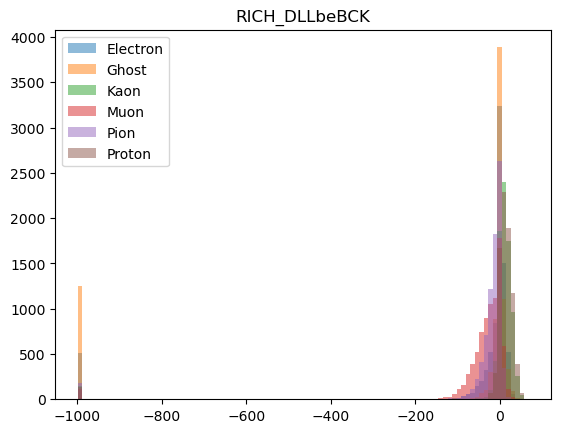

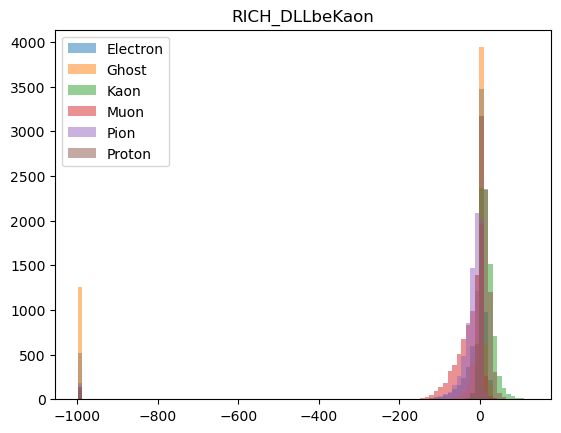

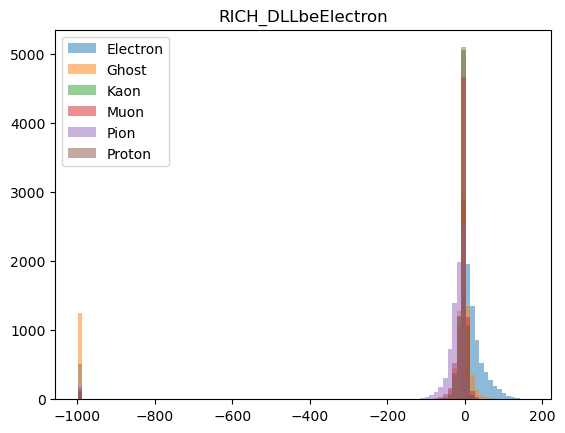

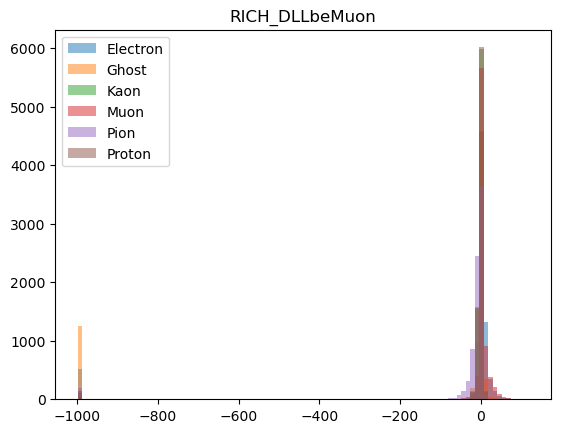

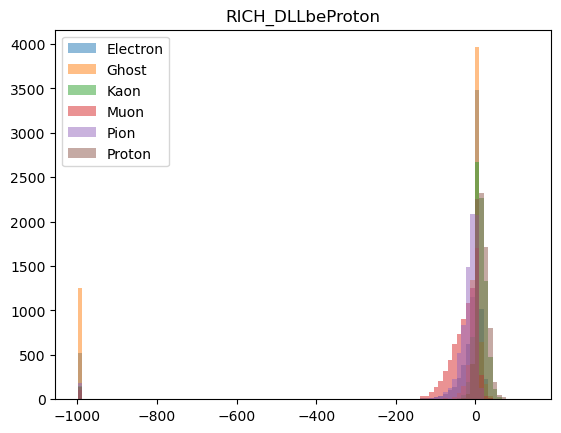

In [14]:
for column in [
    "RICH_DLLbeBCK",
    "RICH_DLLbeKaon",
    "RICH_DLLbeElectron",
    "RICH_DLLbeMuon",
    "RICH_DLLbeProton"
]:
    plt.figure()
    visualize(X_train[column], y_train)
    plt.title(column)
    plt.show()

Note that there is some kind of "exit code" in these floating point variables (maybe in others as well? can you check that?). What should we do with it?

Here's an example feature transformation replacing these values with the mean of the distribution. **Note: this drops potentially important information. A better way might be to also encode these exit codes into new binary features (e.g. `isExitCode_RICH_DLLbeProton`, etc.)**

**Bonus task:** Fix other exit codes (can you find all variables with exit codes and transform them?)

In [15]:
from sklearn.base import TransformerMixin

class FeatureExpansion(TransformerMixin):
    def __init__(self, dll_threshold=-900):
        super().__init__()

        self.features = [
            "RICH_DLLbeBCK",
            "RICH_DLLbeKaon",
            "RICH_DLLbeElectron",
            "RICH_DLLbeMuon",
            "RICH_DLLbeProton"
        ]
        self.dll_threshold = dll_threshold

    def fit(self, X, y):
        self.mean_vals = [
            X[f][X[f] >= self.dll_threshold].mean()
            for f in self.features
        ]
        return self

    def transform(self, X):
        X = X.copy() # to avoid modifying the original dataset
        
        for f, mean in zip(self.features, self.mean_vals):
            X.loc[X[f] < self.dll_threshold,f] = mean
        
        return X

Here's an example transformation of the train dataset:

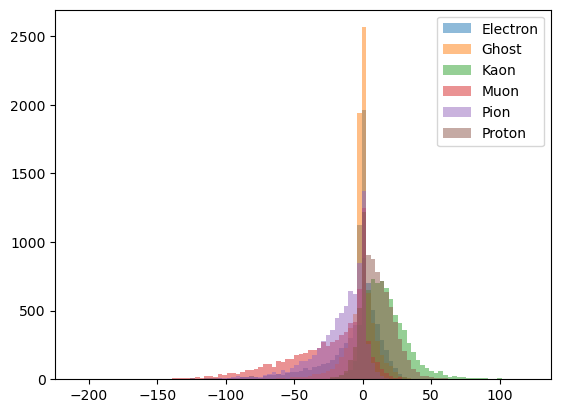

In [16]:
visualize(FeatureExpansion().fit_transform(X_train, y_train)['RICH_DLLbeKaon'], y_train)

In [17]:
model_cleaned = make_pipeline(
    FeatureExpansion(),
    StandardScaler(),
    LGBMClassifier(**default_params),
)
model_cleaned.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7789
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 49
[LightGBM] [Info] Start training from score -1.782800
[LightGBM] [Info] Start training from score -1.781438
[LightGBM] [Info] Start training from score -1.790885
[LightGBM] [Info] Start training from score -1.789637
[LightGBM] [Info] Start training from score -1.812217
[LightGBM] [Info] Start training from score -1.793887


Pipeline(steps=[('featureexpansion',
                 <__main__.FeatureExpansion object at 0x14f7b5ee0>),
                ('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(max_bins=255, num_class=6,
                                objective='multiclass', reg_alpha=0,
                                reg_lambda=0))])

In [18]:
print_accuracy(model_cleaned)

Train accuracy: 0.8553333333333333
Test accuracy:  0.7483333333333333


### Quality metrics

As we are doing physics, we should not be satisfied with a single global performance measure. Instead we want to understand the strong and weak sides of our models. For the sake of an example, below there's some code to plot signal efficiency as a function of particle momentum.

In [19]:
import matplotlib

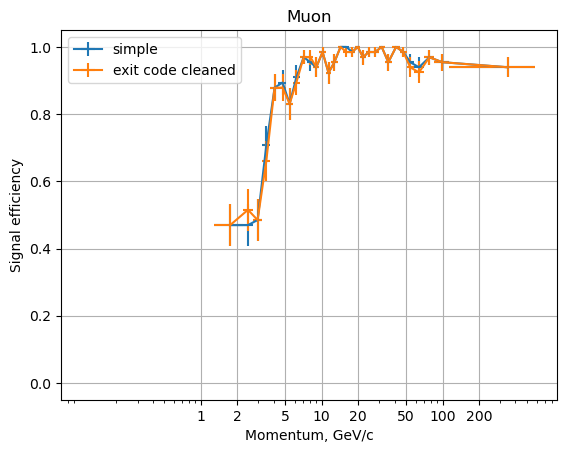

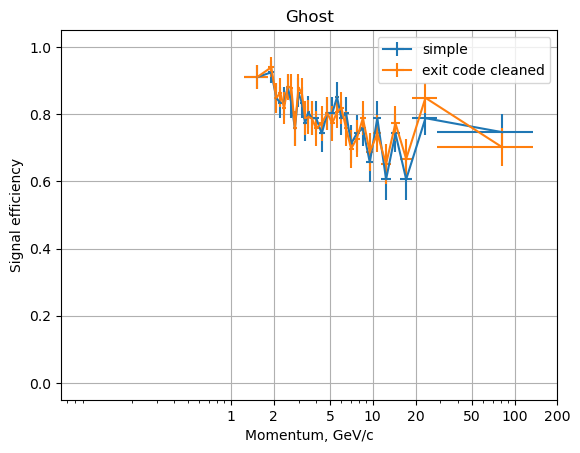

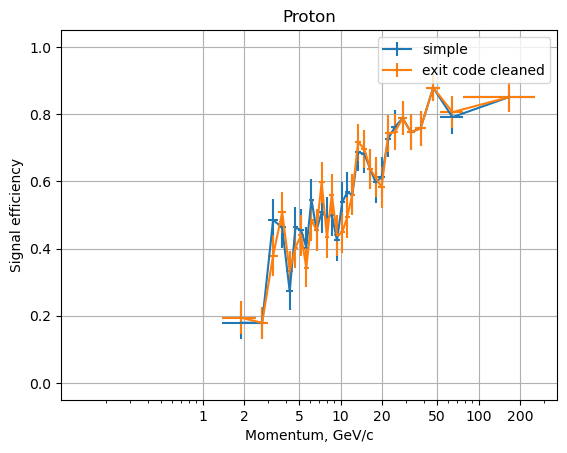

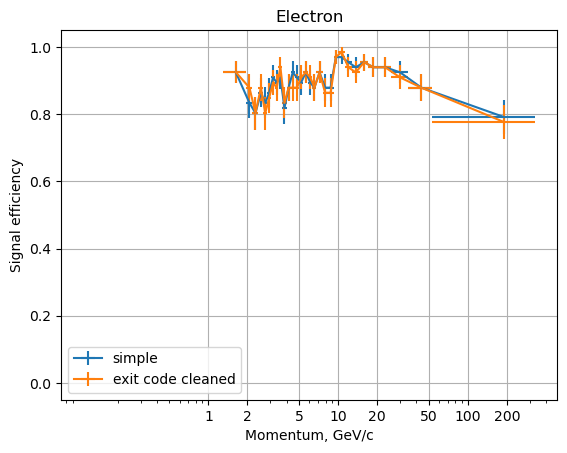

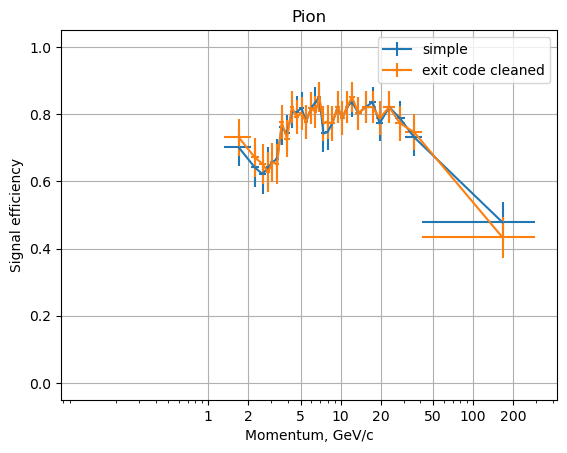

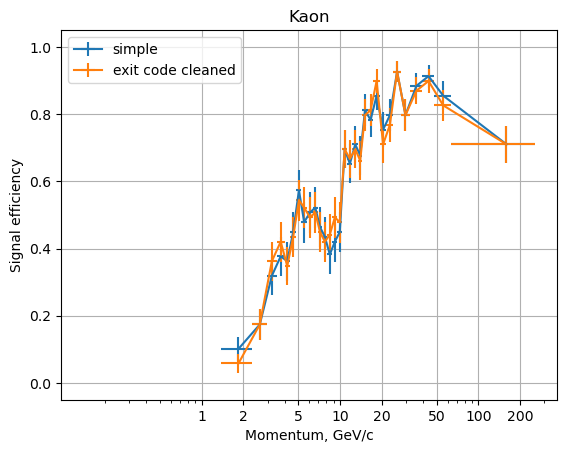

In [20]:
def plot_efficiency(X, y, prediction, particle, **kwargs):
    prediction = (prediction == particle)
    selection = (y == particle)
    p = X['TrackP'] / 1000.
    
    tmp_dataset = pd.DataFrame({'p' : p[selection], 'prediction' : prediction[selection]})
    tmp_dataset['p_bin'] = pd.qcut(tmp_dataset['p'], 30)
    
    group = tmp_dataset.groupby('p_bin',observed=False)['prediction']
    efficiency = group.mean()
    efficiency_err = group.std() / group.count()**0.5
    
    p_mid = efficiency.index.categories.mid
    p_err = (efficiency.index.categories.right - efficiency.index.categories.left) / 2
    
    plt.errorbar(
        x=p_mid,
        y=efficiency,
        xerr=p_err,
        yerr=efficiency_err,
        **kwargs
    )
    plt.grid(True)
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().set_xticks([1, 2, 5, 10, 20, 50, 100, 200])
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Momentum, GeV/c')
    plt.ylabel('Signal efficiency')

for particle in y.unique():
    plt.figure()
    plot_efficiency(X_test, y_test, model.predict(X_test), particle, label='simple')
    plot_efficiency(X_test, y_test, model_cleaned.predict(X_test), particle, label='exit code cleaned')
    plt.legend()
    plt.title(particle)
    plt.show()

### Label-based Metrics

Consider a confusion matrix:

<center><img src='img/binary_conf.png'></center>

* TP (true positive) - correctly predicted positives
* FP (false positive) - incorrectly predicted negatives (1st order error)
* FN (false negative) - incorrectly predicted positives (2nd order error)
* TN (true negative) - currectly predicted negatives
* Pos (Neg) - total number of positives (negatives)

Quality metrics:

* $ \text{Accuracy} = \frac{TP + TN}{Pos+Neg}$
* $ \text{Error rate} = 1 -\text{accuracy}$
* $ \text{Precision} =\frac{TP}{TP + FP}$ 
* $ \text{Recall} =\frac{TP}{TP + FN} = \frac{TP}{Pos}$

### Exercise:
Complete a function that computes TP, FP, TN, FN, Accuracy, Error rate, Precision and Recall metrics for our multi-class BDT and a given target class. Note each target class will correspond to its own set of metrics. 

Hint: You can code these yourself or make use of sklearn functions, eg. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [24]:
def quality_metrics_report(y_true, y_pred, target):
    """
    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    target: string with class name
        Target class for which to evaluate metrics
        
    Returns
    -------
    List of metric values: [tp, fp, fn, tn, accuracy, error_rate, precision, recall]
    """
    # your code here
    raise NotImplementedError
    
    return [tp, fp, fn, tn, accuracy, error_rate, precision, recall]

Solution:

```
    tp = np.sum(np.logical_and(y_true==target, y_pred==target))
    fp = np.sum(np.logical_and(y_true!=target, y_pred==target))
    fn = np.sum(np.logical_and(y_true==target, y_pred!=target))
    tn = np.sum(np.logical_and(y_true!=target, y_pred!=target))

    accuracy = (tp+tn)/(tp+tn+fn+fp)
    error_rate = 1-accuracy
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    # Alt. using scikit-learn helpers:
    accuracy = accuracy_score(y_true==target, y_pred==target)
    precision = precision_score(y_true==target, y_pred==target)
    recall = recall_score(y_true==target, y_pred==target)
```

In [32]:
# Test your function:
np.testing.assert_almost_equal(
    quality_metrics_report(np.array([0, 1, 0, 1]), np.array([1, 1, 1, 0]),target=1),
    [1, 2, 1, 0, 0.25, 0.75, 0.3333333333333333, 0.5]
)

Now let's compute these quality metrics for each class

In [25]:
metrics_report = pd.DataFrame(columns = ['TP', 'FP', 'FN', 'TN', 'Accuracy', 'Error rate', 'Precision', 'Recall'])
y_pred = model_cleaned.predict(X_test)
for target in model.classes_:
    metrics = quality_metrics_report(y_test, y_pred, target)
    metrics_report.loc[target,:] = metrics

metrics_report

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
Electron,1771,273,211,9745,0.959667,0.040333,0.866438,0.893542
Ghost,1574,573,412,9441,0.917917,0.082083,0.733116,0.792548
Kaon,1231,758,835,9176,0.86725,0.13275,0.618904,0.595837
Muon,1769,187,202,9842,0.967583,0.032417,0.904397,0.897514
Pion,1517,588,482,9413,0.910833,0.089167,0.720665,0.758879
Proton,1118,641,878,9363,0.873417,0.126583,0.635588,0.56012


## Probability-based Metrics

### ROC curve

The receiver operating characteristic curve (ROC) measures how well a classifier separates two classes. 

Let $y_{\rm i}$ is a true label and $\hat{y}_{\rm i}$ is a predicted score for the $i^{\rm th}$ observation. 

The numbers of positive and negative observations: $\mathcal{I}_{\rm 1} = \{i: y_{\rm i}=1\}$ and $\mathcal{I}_{\rm 0} = \{i: y_{\rm i}=0\}$. 

The sum of observation weights for each class: $W_{\rm 1} = \sum_{i \in \mathcal{I}_{\rm 1}} w_{\rm i}$ and  $W_{\rm 0} = \sum_{i \in \mathcal{I}_{\rm 0}} w_{\rm i}$. 

For each predicted score threshold value $\tau$, True Positive Rate (TPR) and False Positive Rate (FPR) are calculated:

\begin{equation}
TPR(\tau) = \frac{1}{W_{\rm 1}} \sum_{i \in \mathcal{I}_{\rm 1}} I[\hat{y}_{\rm i} \ge \tau] w_{\rm i}
\end{equation}

\begin{equation}
FPR(\tau) = \frac{1}{W_{\rm 0}} \sum_{i \in \mathcal{I}_{\rm 0}} I[\hat{y}_{\rm i} \ge \tau] w_{\rm i}
\end{equation}

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

### Exercise:
Complete the function below, that computes a ROC curve and ROC AUC for a classifier.

**Hints:** 
- use `roc_curve` and `auc` from `from sklearn.metrics`.
- Previously we used `model.predict(X_test)` to return the predicted classes. But to calculate the ROC curve we need the classification scores for each class. These can be returned using `model.predict_proba(X_test)`. This will return a score for every class - the ordering of the classes can be found by printing `model.classes_`. You'll need to retrieve the slice of the scoes corresponding to the target class under consideration.

In [28]:
from sklearn.metrics import roc_curve, auc

def roc_curve_report(y_true, target):
    """
    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    target: string with class name
        Target class for which to evaluate ROC curve
    y_proba: array-like of shape (n_samples,)
        Predicted probabilities of the positive class predicted by a classifier.
        
    Returns
    -------
    fpr : array, shape = [>2]
        Increasing false positive rates such that element i is the false
        positive rate of predictions with score >= thresholds[i].
    tpr : array, shape = [>2]
        Increasing true positive rates such that element i is the true
        positive rate of predictions with score >= thresholds[i].
    roc_auc : float
        Area under the ROC curve defined by the fpr and tpr.
    """
    
    # your code here
    raise NotImplementedError
    
    return fpr, tpr, roc_auc

Solution:

```
    y_score = model.predict_proba(X_test)
    index = np.where(model.classes_==target)[0][0]
    fpr, tpr, _ = roc_curve(y_true==target, y_score[:,index])
    roc_auc = auc(fpr,tpr)
    
```

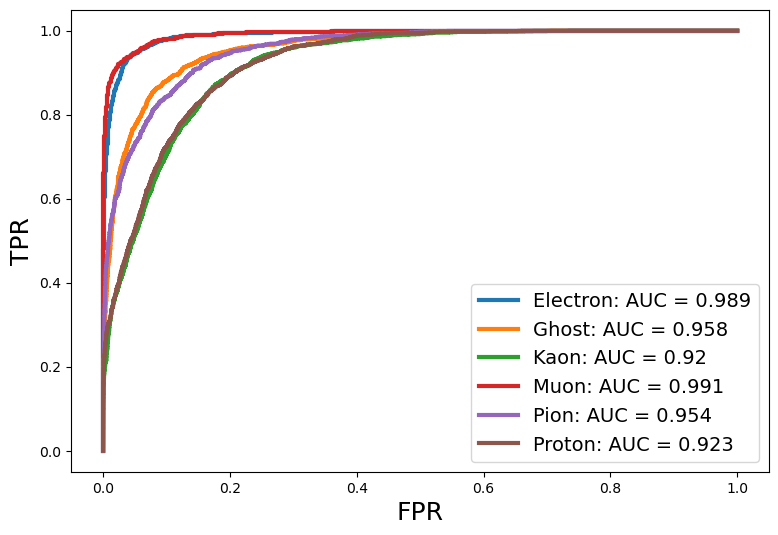

In [33]:
plt.figure(figsize=(9,6))
for target in model.classes_:
    report = roc_curve_report(y_test, target)
    plt.plot(report[0], report[1], linewidth=3, label=f'{target}: AUC = {round(report[2],3)}')
plt.xlabel('FPR',size=18)
plt.ylabel('TPR',size=18)

plt.legend(loc='best',fontsize=14)
plt.show()

## Feature importances and selection

Let's see which features are most important, and whether we can simplify our model by removing some without sacrificing performance. There are several methods for ranking feature importance:

#### 1) Gradient boosting importance

<center><img src="img/tree.png" width="400"></center>

Let $T(f)$ be the set of all nodes which use feature $f$ to make split. Then, feature importance $Imp(f)$ of $f$:

$$
Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t)
$$

$$
\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c)
$$

where
- $n_{t}$ - number of objects in node $t$;
- $I(t)$ – impurity function (gini, cross-entropy, MSE) value for the node.

Feature importances estimated by each tree in an ensemble are averaged over all trees in this ensemble.

In [162]:
# this function will be used just to plot feature importances

def plot_feature_importances(f_imps, f_names):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(int)
    fig, ax = plt.subplots(figsize=(10,7),dpi=200)
    ax.barh(yy, f_imps[sort_inds])
    ax.set_yticks(yy, f_names[sort_inds], size=5)
    ax.set_xlabel("Feature importance", size=14)
    plt.show()

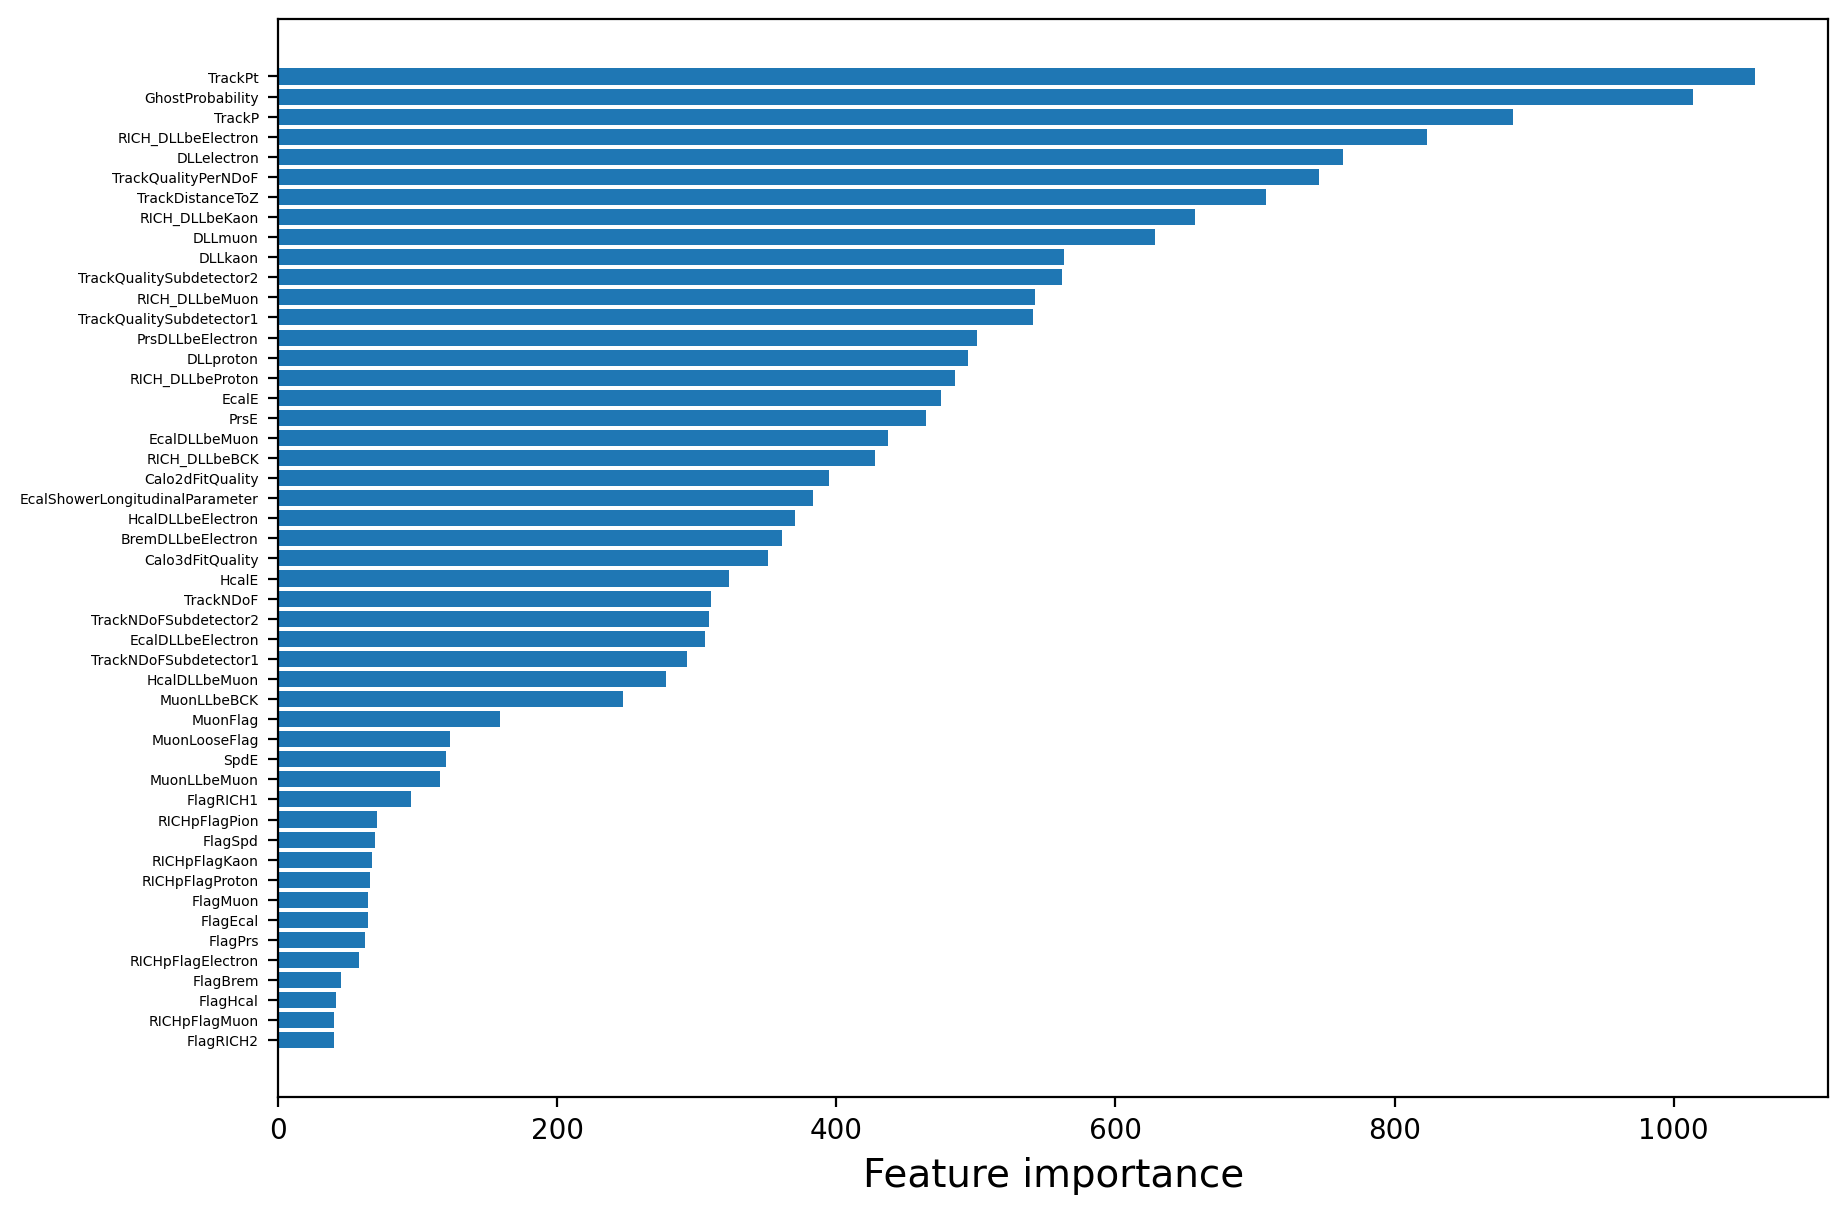

In [164]:
plot_feature_importances(model_cleaned.steps[2][1].feature_importances_, model_cleaned.steps[2][1].feature_name_)

#### 2) Permuation importance
Algorithm:
- Train your model
- Calculate quality measure $Q_0$ on the test set
- For a feature $f$:
 - Replace given values with random values from the same distribution (perform random shuffling)
 - Calculate quality measure $Q_f$ on the test set
 - Estimate feature importance: $Imp(f)=Q_0 - Q_f$

Exercise: Estimate feature importances using general algorithm described above. 

**Hint:** to shuffle the rows of a pandas dataframe, you can use `df.sample(frac=1, random_state=10)`
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html 

Note that, while we don't use it here, there is a scikit-learn helper function to calculate permutation importance:
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [158]:
def get_perm_imp(X_test, y_test, model):
    """
    Estimate feature importances using permutation importance

    Parameters:
    -----------
    X_test: pandas dataframe
        Test input data
    y_test: pandas dataframe
        True class labels
    model: object
        A classifier fitted on the train sample
    
    Returns:
    --------
    f_imps_gen: numpy.array
        Estimated feature importances.
    """
    
    # define a list for the feature importances
    f_imps_gen = []

    # calculate the base quality value according to the algorithm
    y_test_proba = model.predict_proba(X_test)
    q_0 = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')

    # for each feature in the sample estimate its importance
    for c in X_test.columns:
        
        # do not forget to make a copy of X_test!
        X_test_copy = X_test.copy()
        
        # shuffle values of the i-th feature and calculate the new roc_auc_score
        # your code here
        # q_f = ...
        raise NotImplementedError
        
        # estimate importance of the feature
        imp = q_0 - q_f
        f_imps_gen.append(imp)
        
    return np.array(f_imps_gen)

Solution:

```
X_test_copy.loc[:,c] = X_test[c].sample(frac=1, random_state=10).values

# calculate quality metric value
y_test_proba = model.predict_proba(X_test_copy)
q_f = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
```

In [159]:
f_imps_perm = get_perm_imp(X_test, y_test, model)

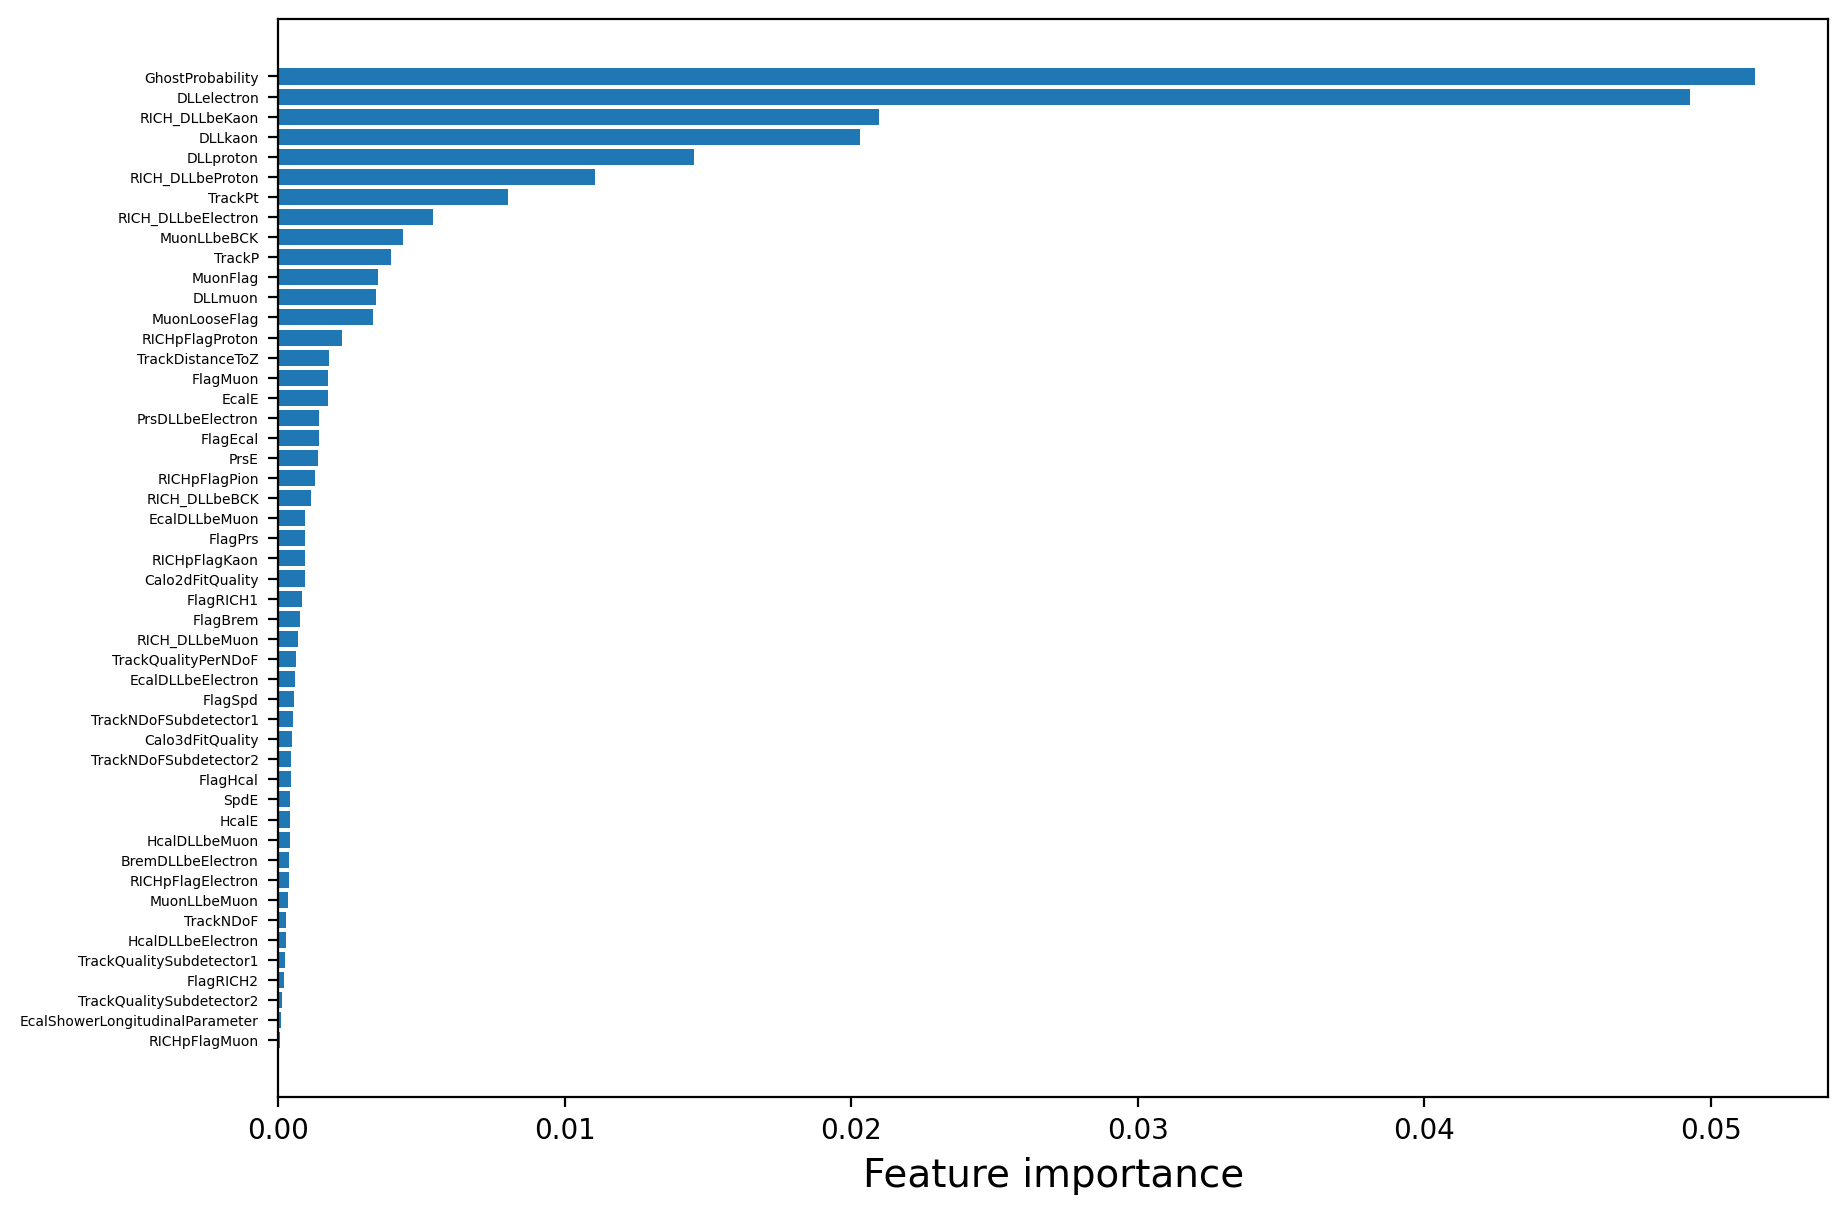

In [163]:
plot_feature_importances(f_imps_perm, X_test.columns)

#### Bonus: 
1) Remove the least important features. What impact does this have on performance?
2) SHAP values use game theory to evaluate feature importance: https://shap.readthedocs.io/en/latest/index.html

## Hyperparameter optimization

Let's see how the ROC-AUC score varies as we change some hyperparameters.

Exercises: 
- Plot the ROC-AUC as a function of hyperparameter X
- Demonstrate grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [43]:
from sklearn.metrics import roc_auc_score
import time
def train_model(**kwargs):
    '''
    Train LightGBM model and return ROC-AUC score for test data and the training time
    Hyperparameters can be specified using kwargs
    '''
    params = dict(default_params)
    params.update(kwargs)

    model = make_pipeline(
        FeatureExpansion(),
        StandardScaler(),
        LGBMClassifier(verbosity=-1,**params),
        )
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    time_taken = time.perf_counter() - start_time
    y_score = model.predict_proba(X_test)
    
    auc = roc_auc_score(y_test, y_score, multi_class='ovr', average='weighted')
    return auc, time_taken
    
def scan_param(hyperparameter, list_of_values, log_scaled_x=True):
    '''
    Scan a list of hyperparameter values and return list of corresponding ROC-AUC scores and training times

    hyperparameter: Name of hyperparameter. Must match a LightGBM hyperparameter.
    list_of_values: list of values to try
    log_scaled_x: True/False to log-scale the x-axis of the resulting plot
    '''
    auc_list = []
    time_list = []
    for _param in list_of_values:
        print(f'Training model with {hyperparameter} = {_param}')
        auc, t = train_model(**{hyperparameter : _param})
        auc_list.append(auc)
        time_list.append(t)

    fig, (ax_1, ax_2) = plt.subplots(1,2,figsize=(12, 5))
    ax_1.plot(list_of_values, auc_list)
    if log_scaled_x:
        ax_1.set_xscale('log')
    ax_2.plot(list_of_values,time_list)
    ax_1.set_xlabel(hyperparameter)
    ax_2.set_xlabel(hyperparameter)
    ax_1.set_ylabel('ROC-AUC')
    ax_2.set_ylabel('Training time (s)')
    plt.show()

Scan some values of the learning rate and plot the impact on the ROC-AUC score

Training model with learning_rate = 0.001
Training model with learning_rate = 0.0021544346900318843
Training model with learning_rate = 0.004641588833612777
Training model with learning_rate = 0.01
Training model with learning_rate = 0.021544346900318832
Training model with learning_rate = 0.046415888336127774
Training model with learning_rate = 0.1
Training model with learning_rate = 0.21544346900318823
Training model with learning_rate = 0.46415888336127775
Training model with learning_rate = 1.0


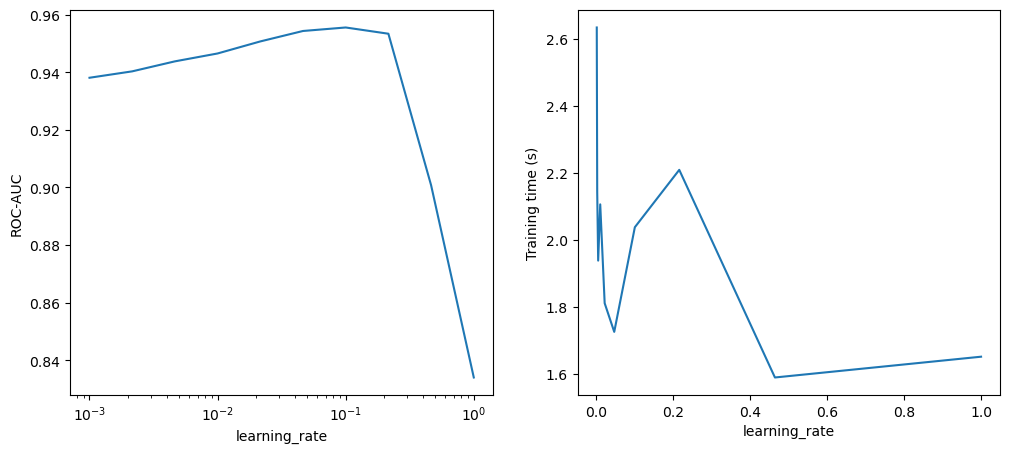

In [45]:
scan_param('learning_rate', np.logspace(-3,0,10), log_scaled_x = True)

#### Exercise: 
Explore the impact of some other hyperparameters. You can find them documented here: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

`default_dict` (defined near the start of the notebook) also contains the defaults:

In [199]:
default_params

{'objective': 'multiclass',
 'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 31,
 'max_bins': 255,
 'max_depth': -1,
 'min_child_samples': 20,
 'reg_lambda': 0,
 'reg_alpha': 0,
 'class_weight': None,
 'n_jobs': None,
 'num_class': 6,
 'boosting_type': 'gbdt',
 'importance_type': 'split'}

#### Bonus exercise: 
Use GridSearchCV to perform a grid scan of hyperparameters: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV

In [49]:
parameters = {'learning_rate': [0.01,0.1], 'num_leaves': [10,30]}
model = make_pipeline(
    FeatureExpansion(),
    StandardScaler(),
    GridSearchCV(LGBMClassifier(verbosity=-1),parameters),
    )
model.fit(X_train, y_train)

Pipeline(steps=[('featureexpansion',
                 <__main__.FeatureExpansion object at 0x317a76b40>),
                ('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=LGBMClassifier(verbosity=-1),
                              param_grid={'learning_rate': [0.01, 0.1],
                                          'num_leaves': [10, 30]}))])

In [65]:
model.steps[2][1].cv_results_

{'mean_fit_time': array([0.98669047, 1.92707024, 0.83628407, 1.59608946]),
 'std_fit_time': array([0.11453529, 0.40007922, 0.05018764, 0.24318184]),
 'mean_score_time': array([0.02495995, 0.03711619, 0.03121839, 0.0484611 ]),
 'std_score_time': array([0.00078392, 0.00179455, 0.00104276, 0.0024315 ]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value=1e+20),
 'param_num_leaves': masked_array(data=[10, 30, 10, 30],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'learning_rate': 0.01, 'num_leaves': 10},
  {'learning_rate': 0.01, 'num_leaves': 30},
  {'learning_rate': 0.1, 'num_leaves': 10},
  {'learning_rate': 0.1, 'num_leaves': 30}],
 'split0_test_score': array([0.71979167, 0.73395833, 0.74958333, 0.7509375 ]),
 'split1_test_score': array([0.71791667, 0.73114583, 0.74322917, 0.7475    ]),
 'split2_test_score': array([0.72208333, 0.735     , 0.75322917, 0.75666667

## K-fold cross-validation
We're currently using 80% of our data for training, and just 20% for testing. What if we wanted to increase the statistics available for evaluation?

<center><img src="img/kfold.png" width="600"></center>

K-Fold:
    
1. Split the data into 𝐾 folds
2. For 𝑖=1,…,𝐾 do: \
    2.1 Keep 𝑖-th fold for validation \
    2.2 Use other 𝐾−1 folds to fit a model \
    2.3 Measure its quality on the validation fold \
3. Estimate mean and standard deviation of the quality metrics


## Exercise

Using K-Fold cross-validation estimate means and standard deviation of the quality metrics for the classifier above. 

**Hint:** use `sklearn.model_selection.KFold(shuffle=True, random_state=11)` as it is shown in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html . Use function `quality_metrics_report` above to compute the quality metrics.

In [34]:
from sklearn.model_selection import KFold

def kfold_uncertainties(X, y, n_splits=5):

    classes = np.unique(y)
    metrics = {c : pd.DataFrame(columns = ['TP', 'FP', 'FN', 'TN', 'Accuracy', 'Error rate', 'Precision', 'Recall']) for c in classes}
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=11)
    N = 0
    for train_index, test_index in kf.split(X):
        N+=1
        
        # fit the model on the train subsample, 
        # get y_test_pred predictions on the test
        # your code here
        raise NotImplementedError
        
        # compute quaility metrics
        for target in classes:
            metrics[target].loc[N,:] = quality_metrics_report(y.loc[test_index], y_test_pred, target)

    for target in classes:
        metrics[target].loc['Mean'] = metrics[target].mean()
        metrics[target].loc['Std'] = metrics[target].std()
    
    return metrics

Solution:

```
        X_train=X.loc[train_index]
        y_train = y.loc[train_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        model_k = make_pipeline(
            FeatureExpansion(),
            StandardScaler(),
            LGBMClassifier(**default_params),
        )
        model_k.fit(X.loc[train_index], y.loc[train_index])

        y_test_pred = model_k.predict(X.loc[test_index])
```

In [68]:
df_dict = kfold_uncertainties(X,y,n_splits=5)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7788
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 49
[LightGBM] [Info] Start training from score -1.785405
[LightGBM] [Info] Start training from score -1.787643
[LightGBM] [Info] Start training from score -1.789886
[LightGBM] [Info] Start training from score -1.791634
[LightGBM] [Info] Start training from score -1.802315
[LightGBM] [Info] Start training from score -1.793761
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7789
[LightGBM] [Info] Number of data points in the train set: 48000

In [71]:
df_dict['Electron']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1776,277,227,9720,0.958,0.042,0.865075,0.88667
2,1784,243,230,9743,0.960583,0.039417,0.880118,0.885799
3,1782,236,233,9749,0.960917,0.039083,0.883053,0.884367
4,1732,268,248,9752,0.957,0.043,0.866,0.874747
5,1787,246,255,9712,0.95825,0.04175,0.878997,0.875122
Mean,1772.2,254.0,238.6,9735.2,0.95895,0.04105,0.874649,0.881341
Std,20.419598,15.70987,10.928861,16.141871,0.001532,0.001532,0.007562,0.005284


In [73]:
df_dict['Ghost']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1561,532,475,9432,0.916083,0.083917,0.745819,0.766699
2,1594,542,421,9443,0.91975,0.08025,0.746255,0.791067
3,1568,564,402,9466,0.9195,0.0805,0.73546,0.795939
4,1642,569,393,9396,0.919833,0.080167,0.74265,0.80688
5,1607,555,406,9432,0.919917,0.080083,0.743293,0.798311
Mean,1594.4,552.4,419.4,9433.8,0.919017,0.080983,0.742695,0.791779
Std,29.110823,13.720058,29.234227,22.61327,0.001473,0.001473,0.003877,0.013546


In [74]:
df_dict['Kaon']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1242,671,816,9271,0.876083,0.123917,0.649242,0.603499
2,1222,697,825,9256,0.873167,0.126833,0.63679,0.596971
3,1231,740,816,9213,0.870333,0.129667,0.624556,0.601368
4,1199,753,793,9255,0.871167,0.128833,0.614242,0.601908
5,1165,758,764,9313,0.873167,0.126833,0.605824,0.60394
Mean,1211.8,723.8,802.8,9261.6,0.872783,0.127217,0.626131,0.601537
Std,27.345201,34.03175,22.103393,32.147162,0.00199,0.00199,0.015517,0.002475


In [75]:
df_dict['Muon']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1796,205,191,9808,0.967,0.033,0.897551,0.903875
2,1781,172,181,9866,0.970583,0.029417,0.91193,0.907747
3,1799,198,195,9808,0.96725,0.03275,0.900851,0.902207
4,1829,187,193,9791,0.968333,0.031667,0.907242,0.90455
5,1830,185,193,9792,0.9685,0.0315,0.908189,0.904597
Mean,1807.0,189.4,190.6,9813.0,0.968333,0.031667,0.905153,0.904595
Std,19.359752,11.359577,4.963869,27.509998,0.001268,0.001268,0.005212,0.001798


In [76]:
df_dict['Pion']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1491,640,430,9439,0.910833,0.089167,0.699672,0.776158
2,1489,649,451,9411,0.908333,0.091667,0.696445,0.767526
3,1469,615,476,9440,0.909083,0.090917,0.704894,0.75527
4,1519,592,482,9407,0.9105,0.0895,0.719564,0.75912
5,1566,577,464,9393,0.91325,0.08675,0.730751,0.771429
Mean,1506.8,614.6,460.6,9418.0,0.9104,0.0896,0.710265,0.765901
Std,33.611903,27.39781,18.62901,18.547237,0.001693,0.001693,0.012948,0.007712


In [77]:
df_dict['Proton']

,TP,FP,FN,TN,Accuracy,Error rate,Precision,Recall
1,1147,662,848,9343,0.874167,0.125833,0.634052,0.574937
2,1168,659,854,9319,0.873917,0.126083,0.639299,0.577646
3,1146,652,883,9319,0.872083,0.127917,0.637375,0.56481
4,1075,635,895,9395,0.8725,0.1275,0.628655,0.545685
5,1095,629,868,9408,0.87525,0.12475,0.635151,0.55782
Mean,1126.2,647.4,869.6,9356.8,0.873583,0.126417,0.634906,0.56418
Std,35.119226,13.124024,17.533967,37.759237,0.001153,0.001153,0.003613,0.011662
